In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.datasets.amass import AMASS
import clip
from src.datasets.get_dataset import get_datasets
import torch
from src.datasets.tools import condense_duplicates
import numpy as np
from src.utils.action_label_to_idx import action_label_to_idx
import src.utils.fixseed  # noqa

fixed seed


In [3]:
from transformers import AutoTokenizer, AutoModel
model_name = 'WhereIsAI/UAE-Large-V1' # 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_encoder = AutoModel.from_pretrained(model_name)

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
def encode_text(text):
    encoder_input = tokenizer(text, return_tensors="pt",
                            padding=True, truncation=True)
    encoder_output = text_encoder(**encoder_input)
    sentence_embeddings = mean_pooling(encoder_output, encoder_input['attention_mask']).detach()
    return sentence_embeddings

In [23]:
import joblib
l2gen = joblib.load('label_mapping_multiple.pt')

In [40]:
word_embeddings = []
for label in action_label_to_idx.keys():
    t1 = encode_text(l2gen[label])
    word_embeddings.append(torch.mean(t1, dim=0))


torch.Size([150, 1024])


In [41]:
word_embeddings = word_embeddings[:60]
print(word_embeddings.size())
labels = torch.tensor(range(60))

torch.Size([60, 1024])


In [42]:
# word_embeddings= torch.stack([torch.mean(torch.stack([encode_text(glabel).squeeze() for glabel in l2gen[label]]), dim=0) for label in list(action_label_to_idx.keys())[:60]])
# print(word_embeddings.size())
# labels = torch.tensor(range(60))

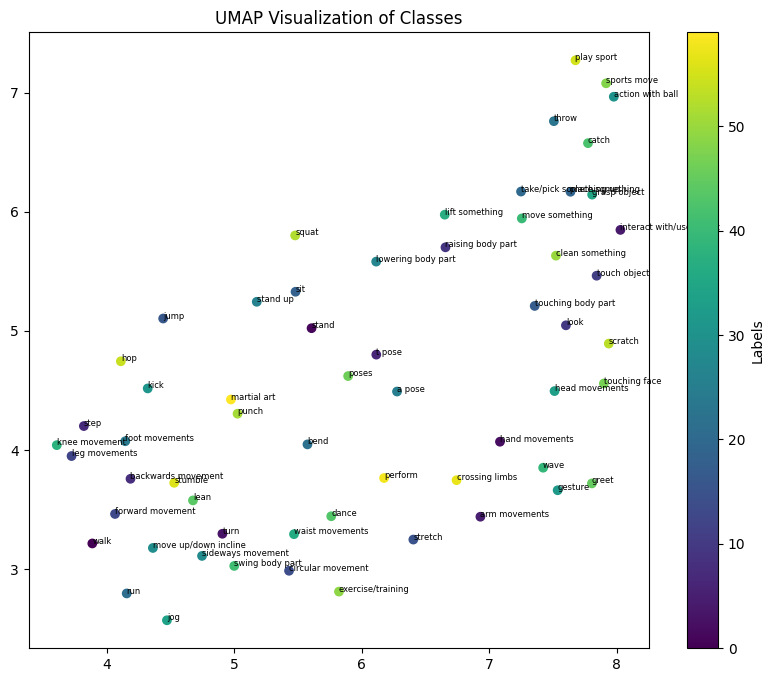

In [43]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import umap
from sklearn.decomposition import PCA
import numpy as np

# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d = tsne.fit_transform(word_embeddings)

pca = PCA(n_components=768)  # Adjust the number of components as needed
pca_word_embeddings = word_embeddings


umap_model = umap.UMAP(metric='cosine')
embeddings_2d = umap_model.fit_transform(pca_word_embeddings)

cmap = matplotlib.colormaps['viridis'] 
normalize = plt.Normalize(vmin=labels.min(), vmax=labels.max())


# Plot the embeddings
plt.figure(figsize=(10, 8))
sc = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=cmap, norm=normalize)

# Add a colorbar
cbar = plt.colorbar(sc, label='Labels')


#Annotate some points with words (optional)
for i, txt in enumerate(range(len(labels))):
    plt.annotate(list(action_label_to_idx.keys())[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=6)

#legend_elements = [Line2D([i], [i], marker='o', color='w', label=f'Article {i}', markerfacecolor=cmap(normalize(i))) for i in range()]
plt.title('UMAP Visualization of Classes')
plt.show()

In [7]:
1/0
parameters = {
    'expname': 'exps',
    'folder': './exps/clip',
    'cuda': True,
    'device': torch.device(type='cuda', index=0),
    'batch_size': 80,
    'num_epochs': 500,
    'lr': 0.0002,
    'snapshot': 20,
    'dataset': 'babel',
    'datapath': './data/babel_30fps_db.pt',
    'num_frames': 60,
    'sampling': 'conseq',
    'sampling_step': 1,
    'pose_rep': 'rot6d',
    'max_len': -1,
    'min_len': -1,
    'num_seq_max': -1,
    'glob': True,
    'glob_rot': [3.141592653589793, 0, 0],
    'translation': True,
    'debug': False,
    'use_action_cat_as_text_labels': False,
    'only_60_classes': True,
    'use_only_15_classes': False,
    'modelname': 'motionclip_transformer_rc_rcxyz_vel',
    'latent_dim': 512,
    'lambda_rc': 95.0,
    'lambda_rcxyz': 95.0,
    'lambda_vel': 95.0,
    'lambda_velxyz': 1.0,
    'jointstype': 'vertices',
    'vertstrans': False,
    'num_layers': 8,
    'activation': 'gelu',
    'clip_image_losses': ['cosine'],
    'clip_text_losses': ['cosine'],
    'clip_lambda_mse': 1.0,
    'clip_lambda_ce': 1.0,
    'clip_lambda_cosine': 1.0,
    'clip_training': '',
    'use_action_cat_as_text_labels': True,
    'clip_layers': 12,
    'modeltype': 'motionclip',
    'archiname': 'transformer',
    'losses': ['rc', 'rcxyz', 'vel'],
    'lambdas': {'rc': 95.0, 'rcxyz': 95.0, 'vel': 95.0},
    'clip_lambdas': {'image': {'cosine': 1.0}, 'text': {'cosine': 1.0}},
    'num_classes': 1,
    'nfeats': 6,
    'njoints': 25,
    'outputxyz': True
}

ZeroDivisionError: division by zero

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device='cpu',
                                    jit=False)  # Must set jit=False for training
train_dataset = get_datasets(parameters=parameters, preprocess=clip_preprocess, split='train')['train']
val_dataset = get_datasets(parameters=parameters, preprocess=clip_preprocess, split='vald')['test']

In [ ]:
db = train_dataset.load_db()

In [ ]:
print(db.keys())

In [ ]:
print(torch.tensor(db['joints3d'][0]).size())

In [ ]:
import torch

# Generate a sample tensor
data = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Define quantiles
quantiles = torch.tensor([0.25, 0.5, 0.75])

# Compute quantiles
quantile_values = torch.quantile(data, quantiles)

# Perform quantile transform
quantile_transformed_data = torch.searchsorted(quantile_values, data.float()) / float(len(quantiles))

print("Original data:", data)
print("Quantile-transformed data:", quantile_transformed_data)

In [ ]:
import joblib
text_descriptions = joblib.load('./data/multiple_captions.pt')

In [ ]:
print(text_descriptions.keys())

In [ ]:
from angle_emb import AnglE

In [ ]:
import torch

# Example tensor matrix
matrix = torch.tensor([[1.0, 2.0, 3.0],
                      [0.0, 0.0, 0.0],
                      [4.0, 5.0, 6.0],
                      [0.0, 1.0, 0.0]])

# Create a mask for non-zero rows
nonzero_rows_mask = (matrix != 0).any(dim=1)

# Filter out rows where all elements are zero
filtered_matrix = matrix[nonzero_rows_mask]

print("Original Matrix:")
print(matrix)
print("\nFiltered Matrix (non-zero rows only):")
print(filtered_matrix)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
print(text_descriptions['step'][0])
print(text_descriptions['leg movements'][0])
sentences = [text_descriptions['leg movements'][50], text_descriptions['leg movements'][0]]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
# sentence_embedfeatures / features.norm(dim=-1, keepdim=True)dings[1] = F.normalize(sentence_embeddings, p=2, dim=1)
sentence_embeddings = sentence_embeddings / sentence_embeddings.norm(dim=-1, keepdim=True)
print("Sentence embeddings:")
print(sentence_embeddings[0] @ sentence_embeddings[1].T)

In [ ]:
text_encoder = AnglE.from_pretrained('WhereIsAI/UAE-Large-V1', pooling_strategy='cls').cuda()

In [ ]:
from src.utils.action_label_to_idx import action_label_to_idx
import torch.nn.functional as F
minim = 300
label1 = text_encoder.encode("going out with the canine", to_numpy=False)
label1 = F.normalize(label1, p=2, dim=1)
label2 = text_encoder.encode("walking the dog", to_numpy=False)
label2 = F.normalize(label2, p=2, dim=1)
print(F.cosine_similarity(label1, label2))
print(label1 @  label2.T)
# for action in action_label_to_idx.keys():
#     label1 = text_encoder.encode(action, to_numpy=False)
#     label2 = text_encoder.encode(action, to_numpy=False)
#     minim = min(minim, label1 @  label2.T)
# print(minim)

In [ ]:
print(train_dataset.__getitem__(100))

In [ ]:
db = train_dataset.load_db()

In [ ]:
from src.datasets.tools import condense_duplicates

print(db.keys())
print(len(db['clip_images']))
print(db['text_raw_labels'][1])

labels = db['text_raw_labels'][1]
labels.append('lie down on stomach')
proc_labels = condense_duplicates(labels)
print(proc_labels)

In [ ]:
print(len(train_dataset))
print(train_dataset.datapath)
db = train_dataset.load_db()


In [ ]:
print(db.keys())
print(condense_duplicates(db['action_cat'][100]))

In [ ]:
import copy
import joblib

def gen_simple_dataset(db, split='train'):
    generated_db = copy.deepcopy(db)
    generated_db['clip_text'] = copy.deepcopy(db['text_proc_labels'])
    curated_idx = []
    for (idx, video_labels) in enumerate(db['text_raw_labels']):
        condensed_labels = condense_duplicates(video_labels)
        action = " and ".join(condensed_labels)
        generated_db['clip_text'][idx] = action
    
    print(generated_db['clip_text'][0])
    joblib.dump(generated_db, f'./data/babel/babel_30fps_{split}.pt')

#gen_simple_dataset(db)

In [ ]:
def gen_captions(llm, sampling_params):
    actions = list(action_label_to_idx.keys())[:60]
    prompts = ['[INST] Describe a person’s body movements who is performing the actions {} in detail [/INST]'
               .format(action) for action in actions]
    outputs = llm.generate(prompts, sampling_params)
    initial_results = [output.outputs[0].text for output in outputs]
    
    captions_mapping = {}
    for (idx, action) in enumerate(actions):
        captions_mapping[action] = [initial_results[idx]]
    prompts = []
    for result in initial_results:
        prompts.extend(['[INST] Paraphrase the following description: {} [/INST]'.format(result)] * 1000)
        
    outputs = llm.generate(prompts, sampling_params)
    for (idx, output) in enumerate(outputs):
        captions_mapping[actions[idx // 1000]].append(output.outputs[0].text)
        
    return captions_mapping
    
def gen_llm_dataset(db, llm, sampling_params, split='train'):
    generated_db = {}
    for key in db.keys():
        generated_db[key] = []
    curated_idx = []
    
    
    for (idx, vide_cat) in enumerate(db['action_cat'][:1]):
        unique_cats = np.unique(vide_cat)
        all_valid_cats = []
        for multi_cats in unique_cats:
            for cat in multi_cats.split(","):
                if cat not in action_label_to_idx:
                    continue
                
                cat_idx = action_label_to_idx[cat]
                if cat_idx >= 60:
                    continue
                all_valid_cats.extend([cat])

        if len(all_valid_cats) == 0:  # No valid category available
            continue
        
        for key in generated_db.keys():
            generated_db[key].append(db[key][idx])
        
        choosen_cat = np.random.choice(all_valid_cats, size=1)[0]
        # condensed_labels = condense_duplicates(video_labels)
        # action = " and ".join(condensed_labels)
        actions.append(choosen_cat)
    print(actions)
    captions = gen_captions(actions, llm, sampling_params)
    generated_db['clip_text'] = []
    for (idx, video_labels) in enumerate(generated_db['action_cat']):
        generated_db['clip_text'].append(captions[idx])
    
    print(len(generated_db['clip_text']))
    print(generated_db['clip_text'][0])
    joblib.dump(generated_db, f'./data/babel_llm_multiple/babel_30fps_{split}.pt')

In [ ]:
print(train_dataset._clip_texts[100])

In [ ]:
import os 
from vllm import LLM, SamplingParams
import time

llm = LLM(model="mistralai/Mistral-7B-Instruct-v0.1")
sampling_params = SamplingParams(temperature=0.7, max_tokens=512)

In [ ]:
captions = gen_captions(llm, sampling_params)

In [ ]:
print(captions['touch object'][:5])
joblib.dump(captions, f'./data/multiple_captions.pt')
1/0

In [ ]:
from src.utils.action_label_to_idx import action_label_to_idx
import joblib
def gen_groundtruth():
    
    action_text_labels = list(action_label_to_idx.keys())
    action_text_labels.sort(key=lambda x: action_label_to_idx[x])
    action_text_labels = action_text_labels[:60]
    print(action_text_labels)
    prompts = ['[INST] Describe a person’s body movements who is performing the actions {} in detail [/INST]'
               .format(action) for action in action_text_labels]
    outputs = llm.generate(prompts, sampling_params)
    return [{'generated': output.outputs[0].text, 'orig': action_text_labels[idx]}  for (idx, output) in enumerate(outputs)]

#joblib.dump(gen_groundtruth(), f'./data/babel_llm/grountruth.pt')

In [ ]:
 gen_llm_dataset(val_dataset.load_db(), llm, sampling_params, split='vald')

In [ ]:
gen_val_dataset = AMASS(clip_preprocess=clip_preprocess, datapath="./data/babel_llm_1/babel_30fps_db.pt")
print(len(gen_val_dataset))
print(gen_val_dataset.__getitem__(0)['all_categories'])

In [ ]:
count = 0
for entry in gen_val_dataset:
    if 'all_categories'  not in entry:
        count += 1
print(count)

In [ ]:
simple_val_dataset = AMASS(clip_preprocess=clip_preprocess, datapath="./data/babel/babel_30fps_db.pt")
print(len(simple_val_dataset))

In [ ]:
gen_train_dataset = AMASS(clip_preprocess=clip_preprocess, datapath="./data/babel_llm_1/babel_30fps_db.pt", split="train")

In [ ]:
db_val = gen_val_dataset.load_db()

In [ ]:
print(db_val.keys())

In [ ]:
print(gen_val_dataset._clip_texts[1])

In [ ]:
print(len(gen_val_dataset._clip_texts))
print(gen_val_dataset.__getitem__(5000)['clip_text'])
print(simple_val_dataset.__getitem__(5000)['clip_text'])

In [ ]:
prompts = ['[INST] Describe a person’s body movements who is performing the actions {} in detail [/INST]'.format('sway')]

In [ ]:
outputs = llm.generate(prompts, sampling_params)
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(generated_text)